# Regularyzacja w modelu regresji - wstęp

In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

from scipy import stats
from patsy import dmatrices

from statsmodels.api import OLS, add_constant
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# Zadanie 1a

Wygeneruj $n$ par punktów (x, y) takich, że
$$
y = x - 2x^2 + 0.5x^3 + e,
$$
gdzie $e\sim\mathcal{N}(\mu, \sigma)$. 
A następnie dopasuj model

a) regresji liniowej: $y=\beta_0 + \beta_1\cdot x$

b) regresji wielomianowej stopnia 2: $y=\beta_0 + \beta_1\cdot x + \beta_2\cdot x^2$,

c) regresji wielomianowej stopnia 3: $y=\beta_0 + \beta_1\cdot x + \beta_2\cdot x^2 + \beta_3\cdot x^3$,

d) regresji wielomianowej stopnia 20: $y=\beta_0 + \beta_1\cdot x + \beta_2\cdot x^2 + \ldots + \beta_{20}\cdot x^{20}$.

Zaznacz na wykresie rozproszenia punktów $(x, y)$ funkcję regresji.

**Wskazówka**: `ols('y ~ x + I(x**k)', data_frame)` ze `statsmodels.formula.api` lub `PolynomialFeatures` z `sklearn.preprocessing`

In [2]:
#generujemy dane
n = 50
x = stats.uniform.rvs(size=n, loc=-3, scale=6)
y = x - 2 * x**2 + 0.5 * x **3 + stats.norm.rvs(size=n, loc=2, scale=2)

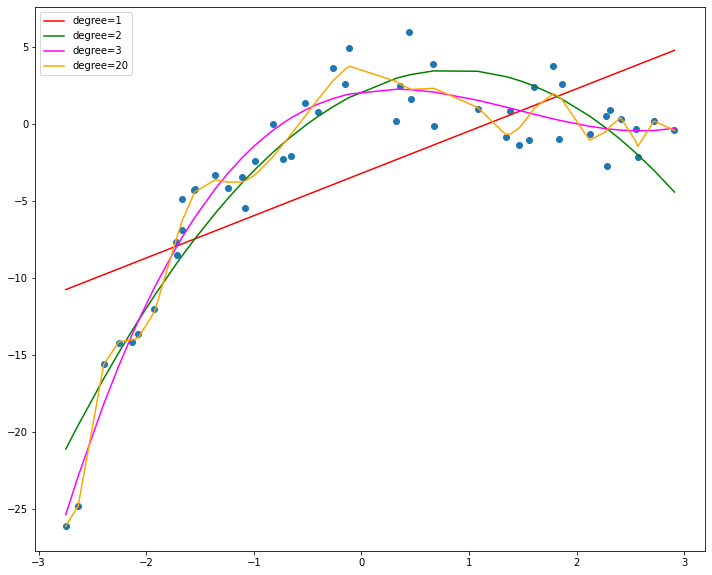

In [3]:
#rysujemy dopasowanie dla modeli wielomianowych o rzędzie wielomianu równym: 1, 2, 3 i 20
import operator

colors = ['red', 'green', 'magenta', 'orange']
degrees = [1, 2, 3, 20]

plt.scatter(x, y)
sort_axis = operator.itemgetter(0)

for i, deg in enumerate(degrees):
    
    if deg == 1:
        X = add_constant(x, prepend=True, has_constant='skip')
    
    else:
        polynomial_features = PolynomialFeatures(degree=deg)
        X = polynomial_features.fit_transform(x.reshape(-1, 1))
    
    model = OLS(endog=y, exog=X).fit()
    
    sorted_zip = sorted(zip(x, model.fittedvalues), key=sort_axis)
    x_range, y_poly_pred = zip(*sorted_zip)
    
    plt.plot(x_range, y_poly_pred, color=colors[i], label="degree={}".format(deg))

plt.legend()

# Zadanie 1b

Dla wygenerowanych par punktów dopasuj model regresji:

a) wielomianowej stopnia 20 z regularyzacją grzbietową (Ridge) z parametrem $\alpha = 0.1$,

b) wielomianowej stopnia 20 z regularyzacją Lasso z parametrem $\alpha = 0.1$.

Powtórz podpunkt a) i b) dla różnych wartości parametru $\alpha$, np. $\alpha \in \{0.001, 0.005, 0.01, 0.5, 1, 5\}$.

In [4]:
X = x.reshape(-1, 1)
polynomial_features = PolynomialFeatures(degree=20, include_bias=False)  # 'sklearn' domyślnie dodaje wyraz wolny do modelu
X20 = polynomial_features.fit_transform(X)

In [5]:
X20.shape

(50, 20)

In [6]:
X20_scale = StandardScaler().fit_transform(X20)  # odjęcie średniej i podzielenie przez odchylenie standardowe

In [7]:
ridge01 = Ridge(alpha=0.1).fit(X=X20_scale, y=y)  # regularyzacja: regresja grzebietowa

In [8]:
lm = LinearRegression().fit(X=X20_scale, y=y)  # zwykły model regresji liniowej

In [9]:
print(ridge01.coef_)
print(lm.coef_)

[ 2.62233357 -5.25651606  1.75139195  2.08530347  1.44713902 -0.37481917
  0.25082053 -1.08225174 -0.22835274 -0.75059692 -0.04765164 -0.25210932
  0.25074606  0.11096659  0.32247529  0.28950389  0.06797946  0.30238599
 -0.47379256  0.17635073]
[ 2.66732090e-01 -4.21027230e+01  3.98710284e+01  7.74376925e+02
  4.10593928e+02 -8.39939613e+03 -8.53678711e+03  5.11569854e+04
  5.24197199e+04 -1.84873312e+05 -1.63462300e+05  4.12631547e+05
  2.91439913e+05 -5.75871472e+05 -3.01464482e+05  4.90589583e+05
  1.68749553e+05 -2.33958742e+05 -3.96058137e+04  4.80031387e+04]


In [10]:
print(ridge01.intercept_)
print(lm.intercept_)

-3.040014201747153
-3.040014201751329


In [11]:
ridge01_fittedvalues = ridge01.predict(X20_scale)

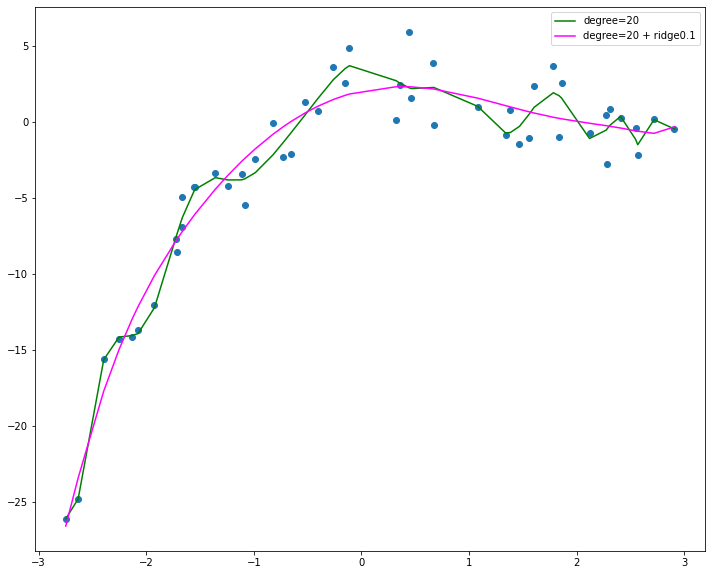

In [12]:
#wykres dopasowania dla regresji wielomianowej bez kary ridge, a także z tą karą

plt.scatter(x, y)
sort_axis = operator.itemgetter(0)

polynomial_features = PolynomialFeatures(degree=20)
X20 = polynomial_features.fit_transform(x.reshape(-1, 1))
model = OLS(endog=y, exog=X20).fit()

sorted_zip = sorted(zip(x, model.fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[1], label="degree={}".format(deg))

sorted_zip = sorted(zip(x, ridge01_fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[2], label="degree={} + ridge0.1".format(deg))

plt.legend()
plt.show()

In [13]:
# a) regularyzacja grzbietowa (Ridge)

ridge01_pipeline = make_pipeline(PolynomialFeatures(degree=20, include_bias=False),
                                 StandardScaler(),
                                 Ridge(alpha=0.1)
                                 )

ridge01_pipeline = ridge01_pipeline.fit(X=X, y=y)

In [14]:
ridge01_pipeline["ridge"].coef_  # można odwoływać się do kolejnych elementów (po indeksie albo po nazwie)

array([ 2.62233357, -5.25651606,  1.75139195,  2.08530347,  1.44713902,
       -0.37481917,  0.25082053, -1.08225174, -0.22835274, -0.75059692,
       -0.04765164, -0.25210932,  0.25074606,  0.11096659,  0.32247529,
        0.28950389,  0.06797946,  0.30238599, -0.47379256,  0.17635073])

In [15]:
#  fitowanie do przeskalowanych zmiennych (poprzednia metoda)

ridge01_fittedvalues = ridge01.predict(X20_scale)
print(ridge01_fittedvalues)

[ -7.18836622   2.33907194  -6.14448618  -0.29773989  -0.59218158
   0.32814357 -23.43807812  -3.49671491   0.22375085  -0.30678176
   2.19245115   1.498232     0.25442051  -0.06747296  -7.68347071
   1.85882469  -2.39719285   0.60682767  -2.58218427   2.18930619
   0.84953468  -0.56543685  -4.41364062   1.09354312   2.32920014
   1.58753616   2.34347136 -10.09941856  -0.73279894  -7.79174526
  -0.80042252   0.68402488   1.00836483  -6.04047888 -12.15903062
  -0.26171824 -26.61176825  -0.38212848   0.04833123   2.33500446
  -7.23482903 -17.7149477   -0.2365712    1.7747216   -0.22840743
   0.62441259  -1.75499652 -13.01505209   1.04244621 -14.97426929]


In [16]:
ridge01_pipeline.predict(X)  # automatyczne skalowanie zmiennych wewnątrz 'make_pipeline()'

array([ -7.18836622,   2.33907194,  -6.14448618,  -0.29773989,
        -0.59218158,   0.32814357, -23.43807812,  -3.49671491,
         0.22375085,  -0.30678176,   2.19245115,   1.498232  ,
         0.25442051,  -0.06747296,  -7.68347071,   1.85882469,
        -2.39719285,   0.60682767,  -2.58218427,   2.18930619,
         0.84953468,  -0.56543685,  -4.41364062,   1.09354312,
         2.32920014,   1.58753616,   2.34347136, -10.09941856,
        -0.73279894,  -7.79174526,  -0.80042252,   0.68402488,
         1.00836483,  -6.04047888, -12.15903062,  -0.26171824,
       -26.61176825,  -0.38212848,   0.04833123,   2.33500446,
        -7.23482903, -17.7149477 ,  -0.2365712 ,   1.7747216 ,
        -0.22840743,   0.62441259,  -1.75499652, -13.01505209,
         1.04244621, -14.97426929])

In [17]:
# b) regularyzacja liniowa (Lasso)

lasso01_pipeline = make_pipeline(PolynomialFeatures(degree=20, include_bias=False),
                                 StandardScaler(),
                                 Lasso(alpha=0.1)
                                 )

lasso01_pipeline = lasso01_pipeline.fit(X=X, y=y)

In [18]:
lasso01_fittedvalues = lasso01_pipeline.predict(X)
lasso01_pipeline.predict(X)  # automatyczne skalowanie zmiennych wewnątrz 'make_pipeline()'

array([ -7.10535957,   2.09091012,  -6.01325101,  -0.26757009,
        -0.53251349,   0.27449106, -22.70184666,  -3.31467519,
         0.14166748,  -0.38366411,   2.01153901,   1.33130629,
         0.18127918,  -0.23897958,  -7.62619569,   1.64730408,
        -2.23765746,   0.60100639,  -2.41677232,   2.00929916,
         0.85748733,  -0.53141257,  -4.23424434,   1.09595114,
         2.09994043,   1.53581737,   2.09827733, -10.16786757,
        -0.50345011,  -7.74024122,  -0.72868624,   0.68502235,
         1.01459832,  -5.9050659 , -12.29538617,  -0.42674953,
       -25.54109936,  -0.49132782,   0.04609737,   2.1023241 ,
        -7.15418024, -17.65432117,  -0.40837382,   1.57344154,
        -0.40201523,   0.56175803,  -1.62270222, -13.16002191,
         0.9314172 , -15.08601479])

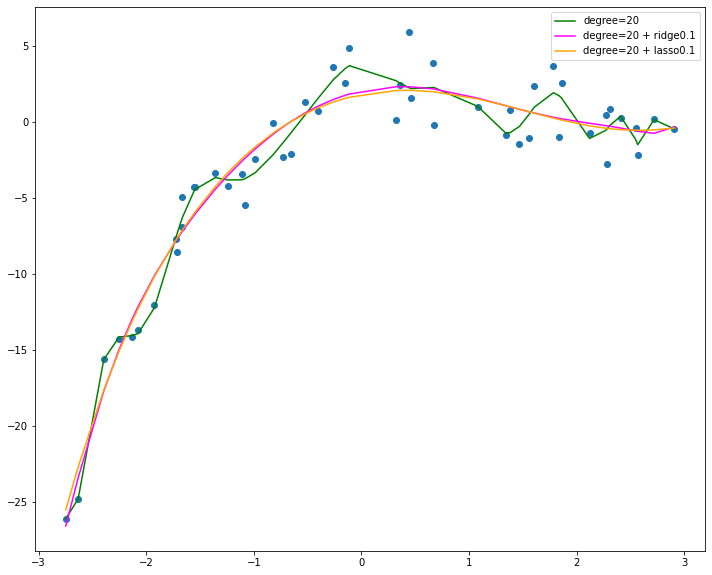

In [19]:
#wykres dopasowania dla regresji wielomianowej bez kary ridge, a także z tą karą

plt.scatter(x, y)
sort_axis = operator.itemgetter(0)

polynomial_features = PolynomialFeatures(degree=20)
X20 = polynomial_features.fit_transform(x.reshape(-1, 1))
model = OLS(endog=y, exog=X20).fit()

sorted_zip = sorted(zip(x, model.fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[1], label="degree={}".format(deg))

sorted_zip = sorted(zip(x, ridge01_fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[2], label="degree={} + ridge0.1".format(deg))

sorted_zip = sorted(zip(x, lasso01_fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[3], label="degree={} + lasso0.1".format(deg))

plt.legend()
plt.show()

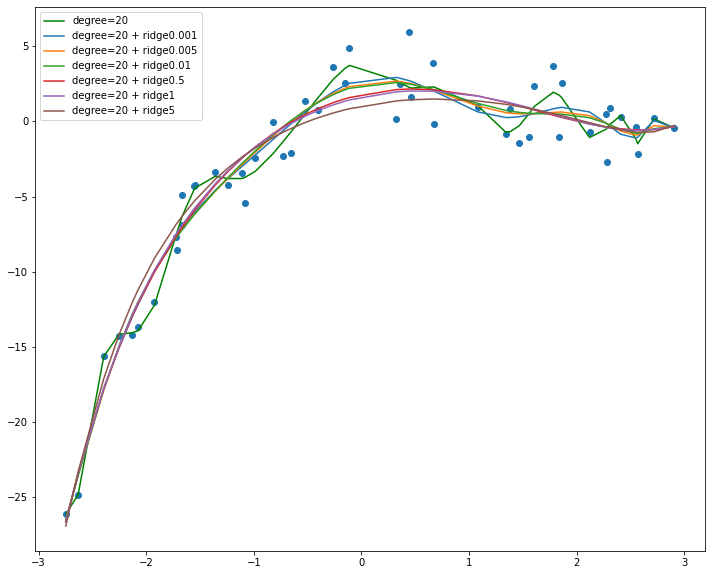

In [20]:
# porównanie różnych hiperparametrów alpha dla regularyzacji grzbietowej (Ridge)

plt.scatter(x, y)
sort_axis = operator.itemgetter(0)

polynomial_features = PolynomialFeatures(degree=20)
X20 = polynomial_features.fit_transform(x.reshape(-1, 1))
model = OLS(endog=y, exog=X20).fit()

sorted_zip = sorted(zip(x, model.fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[1], label="degree={}".format(deg))

alpha_values = [0.001, 0.005, 0.01, 0.5, 1, 5]
for alpha in alpha_values:
    ridge01_pipeline = make_pipeline(PolynomialFeatures(degree=20, include_bias=False),
                                     StandardScaler(),
                                     Ridge(alpha=alpha)
                                     )

    ridge01_pipeline = ridge01_pipeline.fit(X=X, y=y)
    ridge01_fittedvalues = ridge01_pipeline.predict(X)

    sorted_zip = sorted(zip(x, ridge01_fittedvalues), key=sort_axis)
    x_range, y_poly_pred = zip(*sorted_zip)
    plt.plot(x_range, y_poly_pred, label="degree={} + ridge{}".format(deg, alpha))

plt.legend()
plt.show()

/home/mdabrowski-phd/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.070e+00, tolerance: 2.295e-01
  model = cd_fast.enet_coordinate_descent(


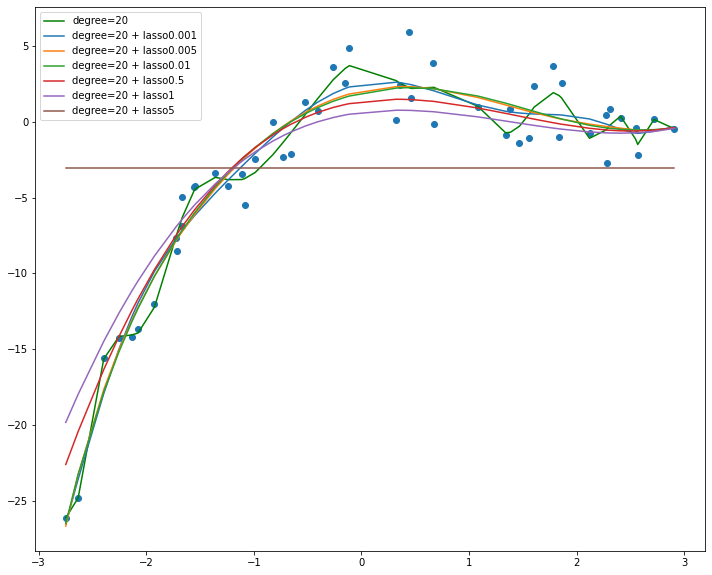

In [21]:
# regularyzacja liniowa (Lasso)

plt.scatter(x, y)
sort_axis = operator.itemgetter(0)

polynomial_features = PolynomialFeatures(degree=20)
X20 = polynomial_features.fit_transform(x.reshape(-1, 1))
model = OLS(endog=y, exog=X20).fit()

sorted_zip = sorted(zip(x, model.fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[1], label="degree={}".format(deg))

alpha_values = [0.001, 0.005, 0.01, 0.5, 1, 5]
for alpha in alpha_values:
    lasso01_pipeline = make_pipeline(PolynomialFeatures(degree=20, include_bias=False),
                                 StandardScaler(),
                                 Lasso(alpha=alpha, max_iter=10_000)
                                 )

    lasso01_pipeline = lasso01_pipeline.fit(X=X, y=y)
    lasso01_fittedvalues = lasso01_pipeline.predict(X)

    sorted_zip = sorted(zip(x, lasso01_fittedvalues), key=sort_axis)
    x_range, y_poly_pred = zip(*sorted_zip)
    plt.plot(x_range, y_poly_pred, label="degree={} + lasso{}".format(deg, alpha))

plt.legend()
plt.show()

# Zadanie 2

Narysuj wykres funkcji 
$$y = cos(x) + \epsilon$$
dla $x \in [\frac{\pi}{2}, \frac{3}{2}\pi]$ oraz $\epsilon \in N(0, 0.15)$.

Dopasuj model regresji:
- liniowej
- wielomianowej stopnia 2, 10 i 20,
- wielomianowej stopnia 20 z regularyzacja Ridge z parametrem $\alpha\in\{0.001, 0.01, 0.1, 1, 2\}$.
- wielomianowej stopnia 20 z regularyzacją Lasso z parametrem $\alpha\in\{0.001, 0.01, 0.1, 1, 2\}$.

**Wskazówka**: Napisz funkcję, która dla dowolnego zbioru dopasuje odpowiedni model.

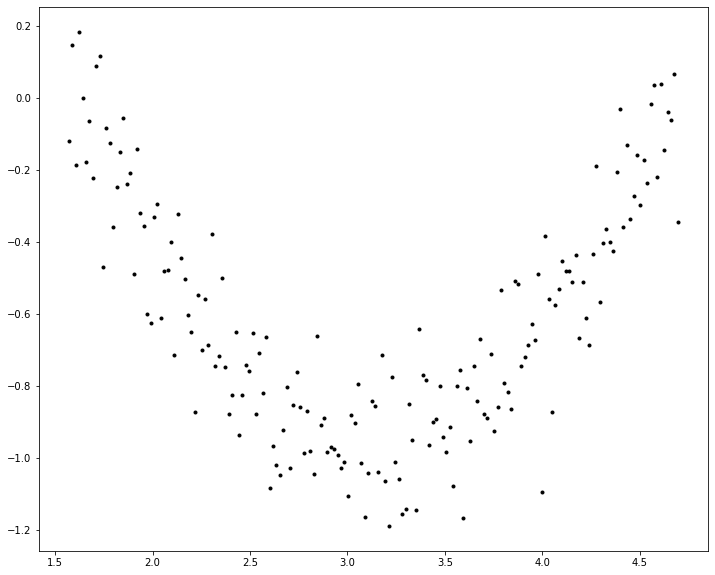

In [22]:
#generacja danych

x = np.array([i * np.pi / 180 for i in range(90, 270, 1)])
X = pd.DataFrame(x)
y = np.cos(x) + np.random.normal(0, 0.15, len(x))

plt.plot(x, y, '.', color='black')

In [23]:
#funkcja dopasowywująca modele, które nas interesują

def fit_model(X, y, model, power):
    
    new_model = make_pipeline(PolynomialFeatures(degree=power, include_bias=False), StandardScaler(), model)
    new_model.fit(X,y)
    
    return(new_model.predict(X))

In [24]:
#tworzymy modele

models = {}
models['linear_regression'] = {'power': 1, 'model': LinearRegression()}
models['polynomial_regression2'] = {'power': 2, 'model': LinearRegression()}
models['polynomial_regression10'] = {'power': 10, 'model': LinearRegression()}
models['polynomial_regression20'] = {'power': 20, 'model': LinearRegression()}
models['ridge_regression_0.1'] = {'power': 20, 'model': Ridge(alpha = 0.1)}
models['lasso_regression_0.1'] = {'power': 20, 'model': Lasso(alpha = 0.1)}

In [25]:
#definiujemy miarę RSS (czyli właściwie MSE razy liczba obserwacji)

def rss_fun(y, y_pred):
    return(sum((y - y_pred)**2))

In [26]:
#liczymy RSS dla każdego modelu na danych na których uczyliśmy model

y_pred_dict = {}
rss = {}

for key, values in zip(models, models.values()):
    
    y_pred = fit_model(X, y, values['model'], values['power'])
    y_pred_dict[key] = y_pred
    rss[key] = rss_fun(y_pred, y)

In [27]:
pd.DataFrame(list(rss.items()), columns = ['Model', 'RSS'])

,Model,RSS
0,linear_regression,19.992347
1,polynomial_regression2,3.430951
2,polynomial_regression10,3.296747
3,polynomial_regression20,3.224378
4,ridge_regression_0.1,3.433172
5,lasso_regression_0.1,16.781749


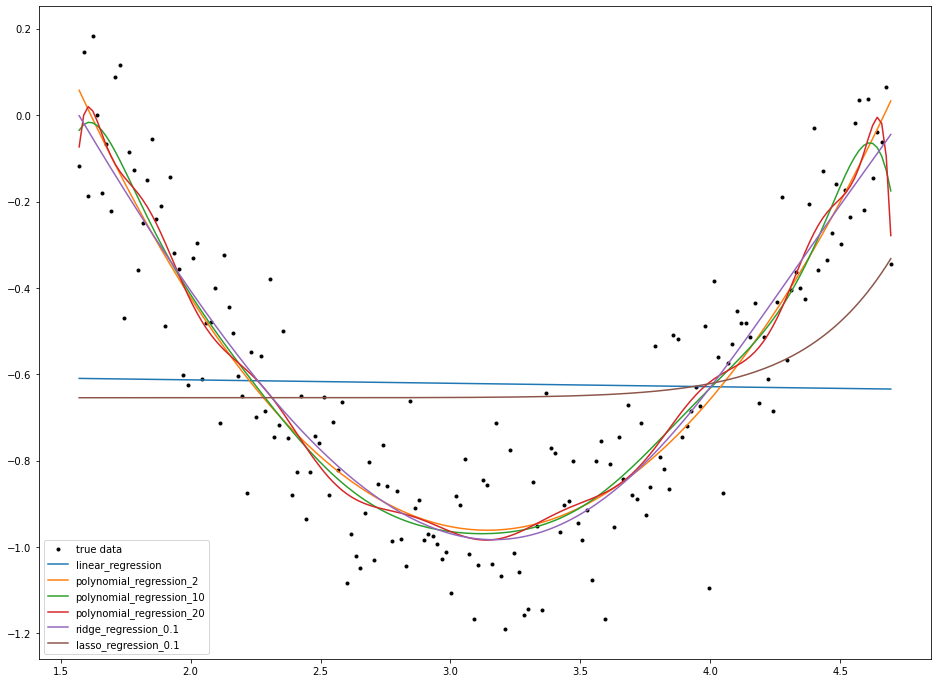

In [28]:
# polynomial 20 przeuczony, ridge z alpha = 0.1 ok, lasso z alpha = 0.1 niedouczony (powinniśmy zmniejszych alpha=0.005)

rcParams['figure.figsize'] = 16, 12

labels = ['true data'] + ['linear_regression', 'polynomial_regression_2', 
                          'polynomial_regression_10', 'polynomial_regression_20', 
                          'ridge_regression_0.1', 'lasso_regression_0.1']

plt.plot(x, y, '.', color = 'black', label="data")

for y_pred in y_pred_dict.values():
    
    plt.plot(x, y_pred)
    plt.legend(labels)